# Testing Model Performances on Machine Learning dataset


This notebook aims to evaluate the performance of five different machine learning models on the task of predicting pharmaceutical removal from wastewater. The goal is to understand how each model performs on the same dataset, comparing both fine-tuned and untuned versions. We will be using r2 scores, rmse, and mae to evaluate the performance.

For each model, we will:
- Train and evaluate an untuned version to establish a baseline performance.
- Apply hyperparameter tuning to create a fine-tuned version and compare its performance against the baseline.

By the end of this analysis, we hope to identify the most effective model and the impact of fine-tuning on its predictive accuracy.

For more detailed information, please refer to https://github.com/J4RELY/IGUIDEpharmEDA


In [2]:
#Import packages
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from random import randint
import warnings
import seaborn as sns
warnings.filterwarnings('ignore') 
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning # Import ConvergenceWarning
from joblib import parallel_backend
from xgboost import XGBRegressor


In [3]:
#load dataset, choose the dataset you want here
original_data_path = 'updated_DATASET.xlsx'
synthetic_data_path = 'synthetic_data.csv'
df = pd.read_excel(original_data_path, engine="openpyxl")
#df = pd.read_csv(synthetic_data_path)
#if necessary concat two dataset for augmented dataset

In [4]:
X = df.drop(['Qm (mg/g)', 'C (wt.%)', 'H  (wt.%)', 'PS (mm)'], axis =1)  # drop the features according to our EDA results
y = df['Qm (mg/g)']  # Target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split dataset in to train and test

In [6]:
scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'] #Our major scorings


## Random Forest Regressor

### Untunned Training with Cross Validation

In [7]:
#untuned cross validation
default_rf = RandomForestRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
untuned_r2_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "r2")

In [8]:
average_untuned_mae_rf = np.mean(untuned_mae_result) *-1
average_untuned_rmse_rf = np.mean(np.sqrt(untuned_rmse_result*-1))
average_untuned_r2_rf = np.mean(untuned_r2_result)


### Finetuning with GridSearchCV

In [9]:
# Define the parameter grid to search through
rf_regressor = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [15, 25, 50, 100, 150],
    'max_depth': [None, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with cross-validation on the training set
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring=scoring, refit="neg_mean_squared_error", cv=5, verbose=1, n_jobs=-1, return_train_score=False)

# Perform the grid search on the training set
grid_search.fit(X_train, y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Extract cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters:  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [10]:
rf_r2 = cv_results[f'mean_test_r2'] *-1
mean_rf_r2 = rf_r2.mean()
rf_mae = cv_results[f'mean_test_neg_mean_absolute_error'] * -1
mean_rf_mae = rf_mae.mean()
rf_rmse = np.sqrt(cv_results[f'mean_test_neg_mean_squared_error'] * -1)
mean_rf_rmse = rf_rmse.mean()
print(f'r2 score: {mean_rf_r2}')
print(f'mae score: {mean_rf_mae}')
print(f'rmse score: {mean_rf_rmse}')

r2 score: 0.47929058005727854
mae score: 30.75651649097101
rmse score: 48.84339110936548


In [11]:
k_folds = KFold(n_splits = 5)
rf_mae = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
rf_r2 = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
rf_rmse = np.sqrt(cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [12]:
best_params_rf = grid_search.best_params_

In [13]:
rf_results = {
    "Tunned": {"r2": rf_r2, "rmse": rf_rmse, "mae": rf_mae},
    "Untunned": {"r2": untuned_r2_result, "rmse": np.sqrt(untuned_rmse_result*-1), "mae": untuned_mae_result *-1}
}

In [14]:
def visualize(dataframe, model):
    records = []
    for category, metrics in dataframe.items():
        for metric, values in metrics.items():
            for value in values:
                records.append([category, metric, value])

    df = pd.DataFrame(records, columns=['Category', 'Metric', 'Value'])
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
    
    # Define y-limits for each metric, adjust it if necessary
    y_limits = {
        'r2': (-0.5, 0.5),
        'rmse': (20, 80),
        'mae': (0, 80)
    }
    
    # Plot each metric in a separate subplot
    for ax, metric in zip(axes, y_limits.keys()):
        sns.boxplot(x='Category', y='Value', data=df[df['Metric'] == metric], ax=ax)
        ax.set_ylim(y_limits[metric])
        ax.set_title(f'{model} Boxplot of {metric.upper()}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Value')
    
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('{}_score_original.png'.format(model), dpi =300)
    plt.show()


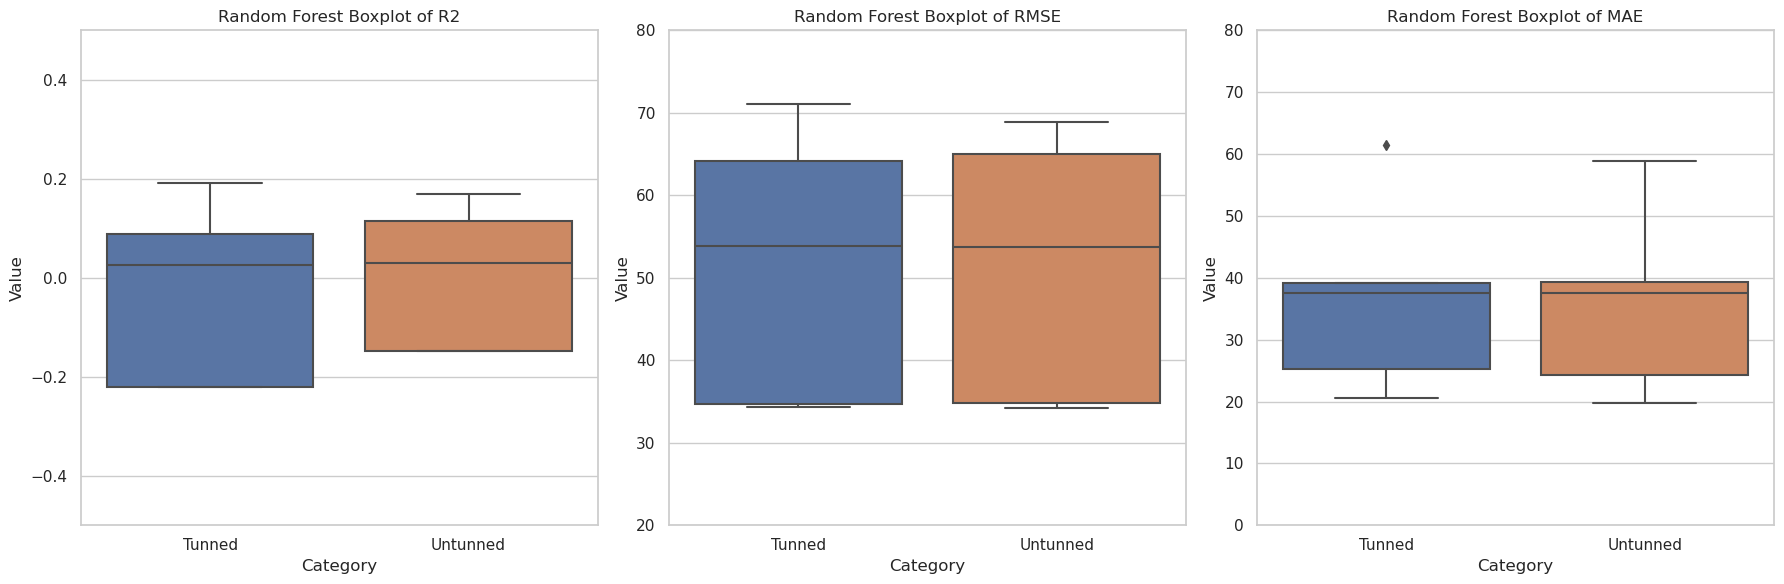

In [15]:
visualize(rf_results, "Random Forest")

## Decision Tree


### Untunned Training with Cross Validation

In [16]:
#untuned decision tree
default_dt = DecisionTreeRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
untuned_r2_result_dt = cross_val_score(default_dt, X, y.values.ravel(), cv = k_folds, scoring= "r2")



In [17]:
average_untuned_mae_dt = np.mean(untuned_mae_result_dt) *-1
average_untuned_rmse_dt = np.mean(np.sqrt(untuned_rmse_result_dt*-1))
average_untuned_r2_dt = np.mean(untuned_r2_result_dt)


### Finetuning with RandomizedSearchCV

In [18]:
def get_rmse_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
    results = {
        'Decision Tree': np.sqrt(dt_scores * -1),
        }
    results = pd.DataFrame(results)
    return results

def get_r2_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "r2")
    results = {
        'Decision Tree': dt_scores * -1,
        }
    results = pd.DataFrame(results)
    return results

def get_mae_errors_cv(X, y, dt, scorer, split=5):
    k_folds = KFold(n_splits = split)
    dt_model = dt
    dt_scores = cross_val_score(dt_model, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
    results = {
        'Decision Tree': dt_scores * -1,
        }
    results = pd.DataFrame(results)
    return results

In [19]:
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': [None, 'auto', 'sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1))
}

dt_model = RandomizedSearchCV(DecisionTreeRegressor()
    ,param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,       # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  )
search_dt = dt_model.fit(X_train, y_train)
search_dt.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'splitter': 'random',
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'max_features': 'log2',
 'max_depth': 14,
 'criterion': 'absolute_error'}

In [20]:
best_params_dt = search_dt.best_params_

In [21]:
dt = DecisionTreeRegressor()
dt.set_params(**search_dt.best_params_)

DecisionTreeRegressor(criterion='absolute_error', max_depth=14,
                      max_features='log2', min_samples_leaf=7,
                      min_samples_split=7, splitter='random')

In [22]:
r2_results = get_r2_errors_cv(X, y, dt, "r2", split=5)
average_r2_dt = np.mean(r2_results.values.flatten())
mae_results = get_mae_errors_cv(X, y, dt, "neg_mean_absolute_error")
average_mae_dt = np.mean(mae_results.values.flatten())
rmse_results = get_rmse_errors_cv(X, y, dt, "neg_mean_squared_error", split=5)
average_rmse_dt = np.mean(rmse_results.values.flatten())

In [23]:
dt_results = {
    "Tunned": {"r2": r2_results.to_numpy().flatten(), "rmse": rmse_results.to_numpy().flatten(), "mae": mae_results.to_numpy().flatten()},
    "Untunned": {"r2": untuned_r2_result_dt, "rmse": np.sqrt(untuned_rmse_result_dt*-1), "mae": untuned_mae_result_dt *-1}
}


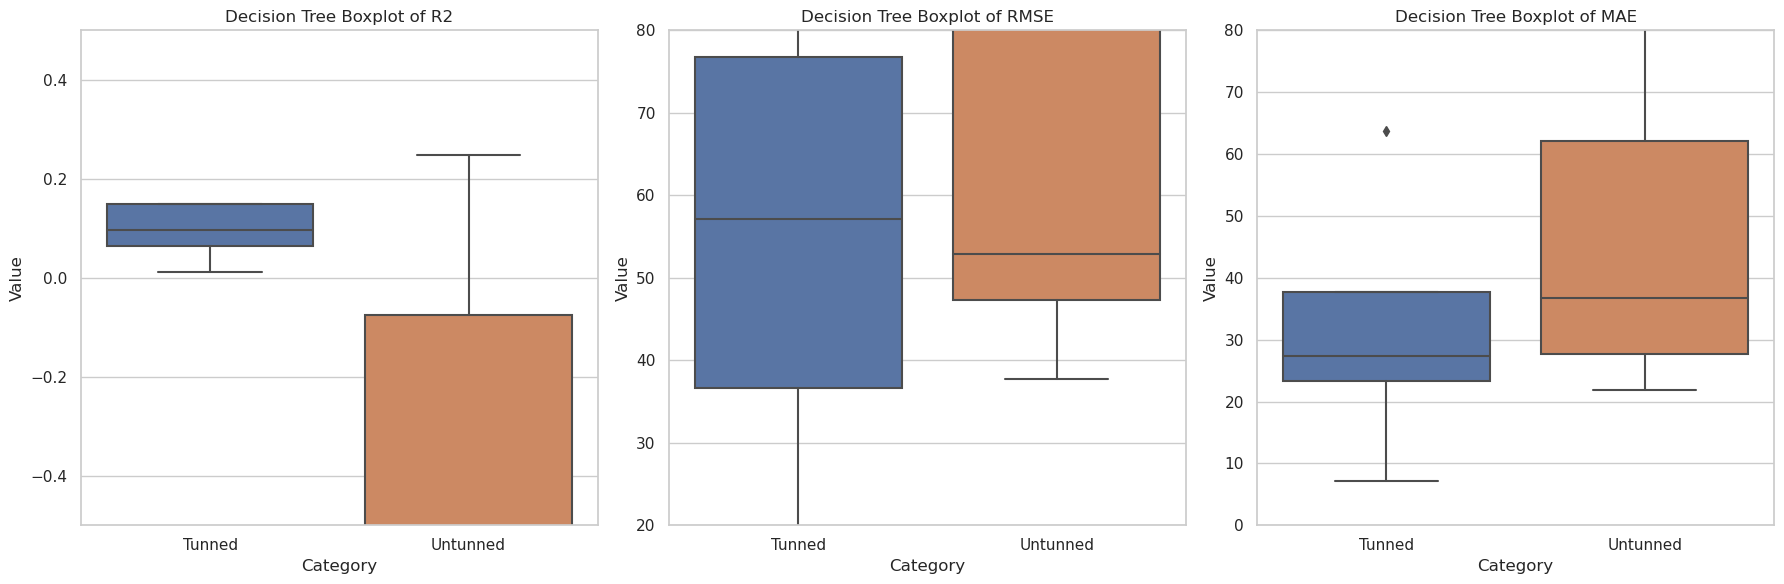

In [24]:
visualize(dt_results, "Decision Tree")

## Xgboost

### Untunned Training with Cross Validation

In [25]:
untunned_xgb_model = XGBRegressor(n_estimators = 200, learning_rate = 0.001)
untunned_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
kfold = KFold(n_splits=5)
untunned_r2_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'r2')
untunned_rmse_results_xgb = np.sqrt(cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_squared_error')*-1)
untunned_mae_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_absolute_error')*-1

In [27]:

untunned_pred = untunned_xgb_model.predict(X_test)


In [28]:
untunned_xgb_rmse = np.sqrt(mean_squared_error(y_test, untunned_pred)) 
print("RMSE : % f" %(untunned_xgb_rmse)) 

RMSE :  48.079548


In [29]:
untunned_xgb_mae = mean_absolute_error(y_test, untunned_pred)
print('mean absolute score:', untunned_xgb_mae)

mean absolute score: 35.111086785507204


In [30]:
untunned_xgb_r2 = r2_score(y_test, untunned_pred)
print('r2 score:',untunned_xgb_r2)

r2 score: 0.12585421817411602


### Finetuning with RandomizedSearchCV

In [31]:
# Randomized Search hyperparameter
xgb_reg = XGBRegressor()
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=50, scoring='r2', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
                                        'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [32]:
k_folds = KFold(n_splits = 5)
xgb_mae = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
xgb_r2 = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
xgb_rmse = np.sqrt(cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [33]:
best_params_xgb = random_search_xgb.best_params_
print("Best parameters found: ", best_params_xgb)

best_model_xgb = random_search_xgb.best_estimator_
tunned_pred = best_model_xgb.predict(X_test)

Best parameters found:  {'subsample': 0.6, 'reg_lambda': 0.2, 'reg_alpha': 0.3, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [34]:
tunned_xgb_rmse = np.sqrt(mean_squared_error(y_test, tunned_pred)) 
print("RMSE : % f" %(tunned_xgb_rmse))
tunned_xgb_mae = mean_absolute_error(y_test, tunned_pred)
print('mean absolute score:', tunned_xgb_mae)
tunned_xgb_r2 = r2_score(y_test, tunned_pred)
print('r2 score:',tunned_xgb_r2)

RMSE :  44.122832
mean absolute score: 33.011986434173586
r2 score: 0.2638100732432651


In [35]:
xgb_results = {
    "Tunned": {"r2": xgb_r2, "rmse": xgb_rmse, "mae": xgb_mae},
    "Untunned": {"r2": untunned_r2_results_xgb, "rmse": untunned_rmse_results_xgb, "mae": untunned_mae_results_xgb}
}
xgb_results

{'Tunned': {'r2': array([-9.46526353,  0.32129686,  0.12737015, -0.01737706, -0.17451524]),
  'rmse': array([29.53026566, 44.93650802, 66.65648532, 36.68341786, 69.70109823]),
  'mae': array([26.90771885, 33.69793083, 42.5820677 , 24.03922745, 60.99115489])},
 'Untunned': {'r2': array([-7.89107373,  0.11195772,  0.10353587, -0.11386045, -0.31629395]),
  'rmse': array([27.21882513, 51.40154965, 67.56065259, 38.38346832, 73.78816939]),
  'mae': array([25.80334027, 35.6217903 , 44.53034017, 29.85397514, 60.57352374])}}

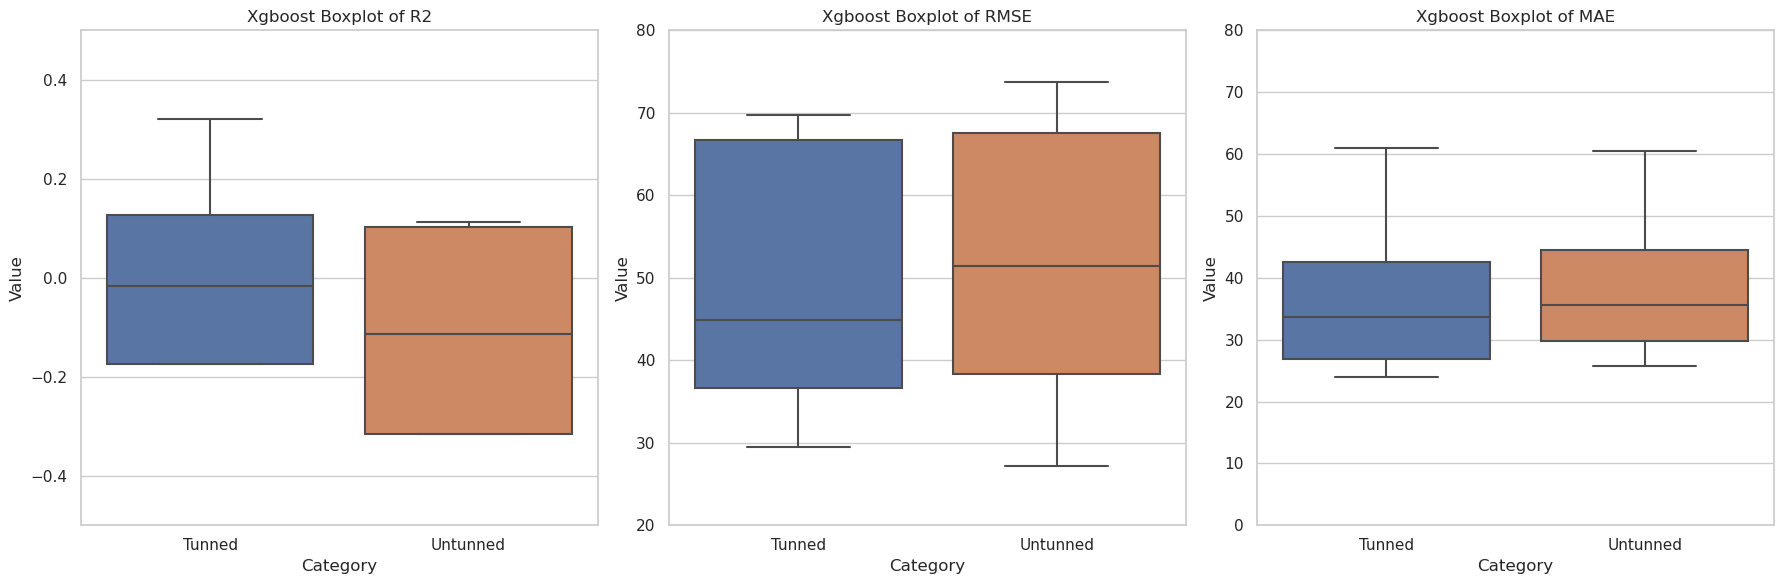

In [36]:
visualize(xgb_results, "Xgboost")

## Gradient Boost

### Untunned Training with Cross Validation

In [37]:
 #Instantiate Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
gbr = GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=0.01,
                                n_estimators=1000,
                                max_depth = 6, 
                                random_state = 42,
                                max_features = 5)
 
# Fit to training set
gbr.fit(X_train, y_train)
 
# Predict on test set
y_pred = gbr.predict(X_test)
 
# test set RMSE
untunned_test_rmse_gb = mean_squared_error(y_test, y_pred) ** (1 / 2)
untunned_test_r2_gb = r2_score(y_test, y_pred)
untunned_test_mae_gb = mean_absolute_error(y_test, y_pred)
# Print rmse
print('Root mean Square error: {:.2f}'.format(untunned_test_rmse_gb))
print('Mean Absolute error: {:.2f}'.format(untunned_test_mae_gb))
print('r2 score: {:.2f}'.format(untunned_test_r2_gb))

Root mean Square error: 40.78
Mean Absolute error: 25.26
r2 score: 0.37


In [38]:
k_folds = KFold(n_splits = 5)
untunned_gb_mae = cross_val_score(gbr, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
untunned_gb_r2 = cross_val_score(gbr, X, y.values.ravel(), cv = k_folds, scoring= "r2")
untunned_gb_rmse = np.sqrt(cross_val_score(gbr, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

### Finetuning with RandomizedSearchCV

In [39]:
param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 2),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'subsample': np.linspace(0.6, 1.0, 5)
}

random_search_gbr = RandomizedSearchCV(
    estimator= GradientBoostingRegressor(),
    scoring=scoring,
    refit="r2",
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # Number of folds in cross-validation
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_gbr.fit(X_train, y_train)

# Extract the best hyperparameters
best_params_gbr = random_search_gbr.best_params_
print("Best Hyperparameters: ", best_params_gbr)

# Extract cross-validation results
cv_results_gbr = pd.DataFrame(random_search_gbr.cv_results_)


Best Hyperparameters:  {'subsample': 0.9, 'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.3}


In [40]:
k_folds = KFold(n_splits = 5)
tunned_mae_gb = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
tunned_r2_gb = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
tunned_rmse_gb = np.sqrt(cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [41]:
gbr_r2 = cv_results_gbr['mean_test_r2'] *-1
mean_gbr_r2 = gbr_r2.mean()
gbr_mae = cv_results_gbr['mean_test_neg_mean_absolute_error'] * -1
mean_gbr_mae = gbr_mae.mean()
gbr_rmse = np.sqrt(cv_results_gbr['mean_test_neg_mean_squared_error'] * -1)
mean_gbr_rmse = gbr_rmse.mean()

In [42]:
gb_results = {
    "Tunned": {"r2": tunned_r2_gb, "rmse": tunned_rmse_gb, "mae": tunned_mae_gb},
    "Untunned": {"r2": untunned_gb_r2, "rmse": untunned_gb_rmse, "mae": untunned_gb_mae}
}
gb_results

{'Tunned': {'r2': array([-3.35508187e+01,  1.67602960e-02,  8.56188709e-02, -8.91054696e-01,
         -3.86480379e-01]),
  'rmse': array([62.64233847, 47.6136975 , 68.77346436, 47.6639387 , 88.50620481]),
  'mae': array([39.10333832, 28.57733137, 36.1965259 , 33.62740718, 67.71611263])},
 'Untunned': {'r2': array([-13.91931148,   0.33198967,   0.08871894,   0.14120819,
          -0.12513746]),
  'rmse': array([35.25872958, 44.58112057, 68.11669205, 33.7033266 , 68.22021517]),
  'mae': array([25.56598725, 33.16324356, 39.67400676, 18.7945624 , 58.68425773])}}

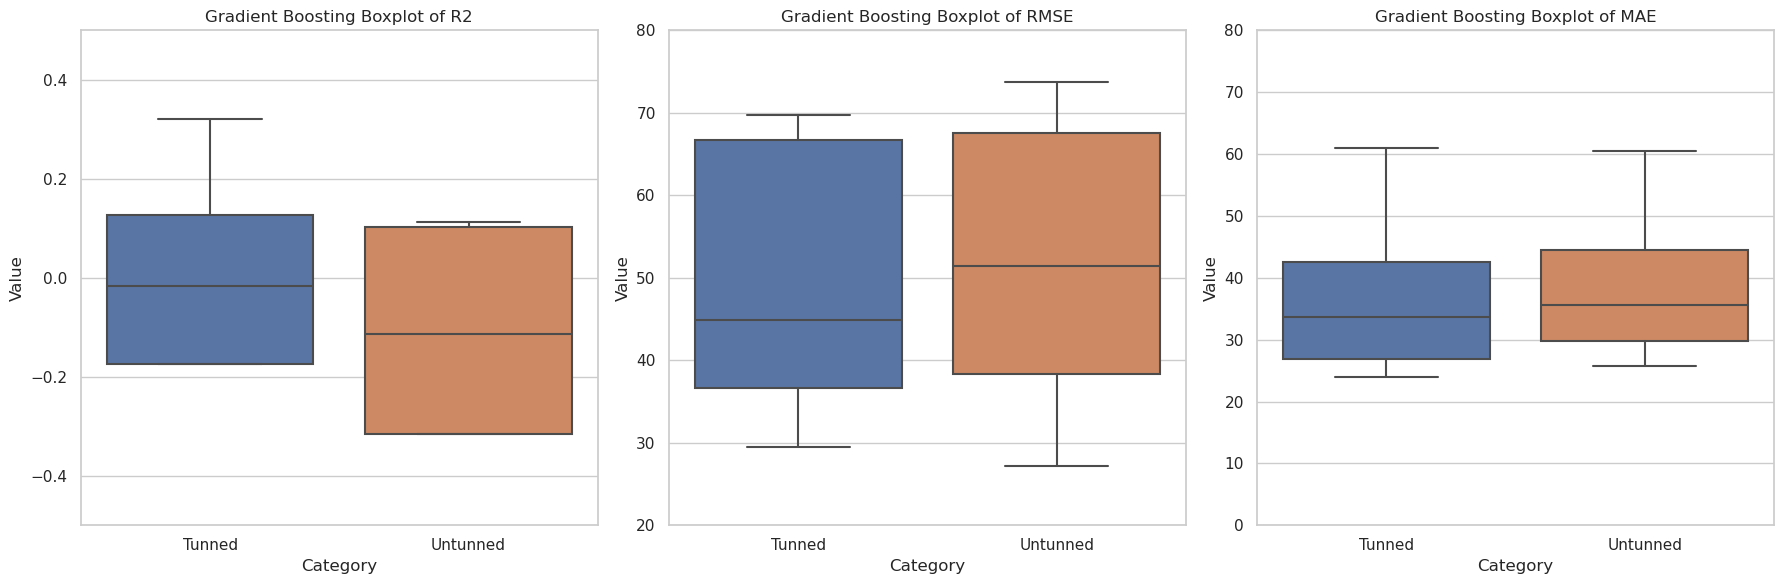

In [43]:
visualize(xgb_results, "Gradient Boosting")

## ANN(Multilayer Perceptron)

### Untunned Training with Cross Validation

In [44]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled =  scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [45]:
# Create the model with increased max_iter
scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}
untunned_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
scores = cross_validate(untunned_mlp, X_train_scaled, y_train, cv=5, scoring=scoring, return_train_score=True)


In [46]:
print("RMSE:", -np.mean(scores['test_rmse']))
print("MAE:", -np.mean(scores['test_mae']))
print("R²:", np.mean(scores['test_r2']))

RMSE: 48.405579389974505
MAE: 35.70849026575733
R²: -0.9683907978339665


In [47]:
untunned_r2_mlp = np.mean(scores['test_r2'])
untunned_rmse_mlp = -np.mean(scores['test_rmse'])
untunned_mae_mlp = -np.mean(scores['test_mae'])


### Finetuning with GridSearchCV(Don't use it on massive dataset)

In [48]:
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (20,), (10, 10), (20, 10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    # 'alpha': [0.0001, 0.001, 0.01],
    # 'batch_size': [10, 20, 40],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],  # Added learning rate initialization
}

In [49]:
# Create the model with increased max_iter
mlp = MLPRegressor(max_iter=2000)

In [50]:
# Perform Grid Search with threading backend
with parallel_backend('threading'):
    grid = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=5, scoring='r2', return_train_score=True)
    grid_result = grid.fit(X_train_scaled, y_train)

# Summarize the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_params_ann = grid_result.best_params_

Best: -0.1410796269043329 using {'activation': 'logistic', 'hidden_layer_sizes': (10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'}


In [51]:
# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_scaled)
mse_ann = mean_squared_error(y_test, y_pred)
mae_ann = mean_absolute_error(y_test, y_pred)
r2_ann = r2_score(y_test, y_pred)
rmse_ann = np.sqrt(mse_ann)
print(f'Test RMSE: {rmse_ann}')
print(f'Test MAE: {mae_ann}')
print(f'Test R2: {r2_ann}')

Test RMSE: 53.67422192699719
Test MAE: 29.802635643314066
Test R2: -0.08941820527613631


In [52]:
k_folds = KFold(n_splits = 5)
tunned_mae_ann = cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
tunned_r2_ann = cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "r2")
tunned_rmse_ann = np.sqrt(cross_val_score(best_model, X_scaled, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [53]:
ann_results = {
    "Tunned": {"r2": tunned_r2_ann, "rmse": tunned_rmse_ann, "mae": tunned_mae_ann},
    "Untunned": {"r2": scores['test_r2'], "rmse": -scores['test_rmse'], "mae": -scores['test_mae']}
}
ann_results

{'Tunned': {'r2': array([-0.39489391, -0.04097873, -0.13765673, -0.01764541, -0.78850195]),
  'rmse': array([11.26097164, 55.45294531, 76.45529524, 36.87043849, 85.57938802]),
  'mae': array([ 9.00056546, 26.47869455, 38.66319921, 23.28552994, 62.48510392])},
 'Untunned': {'r2': array([-0.16958752,  0.67014063, -1.67751422,  0.42661669, -4.09160958]),
  'rmse': array([86.53961533, 42.34830504, 39.00174645, 30.25462862, 43.88360151]),
  'mae': array([58.44343015, 30.71474014, 28.36103084, 26.12346546, 34.89978473])}}

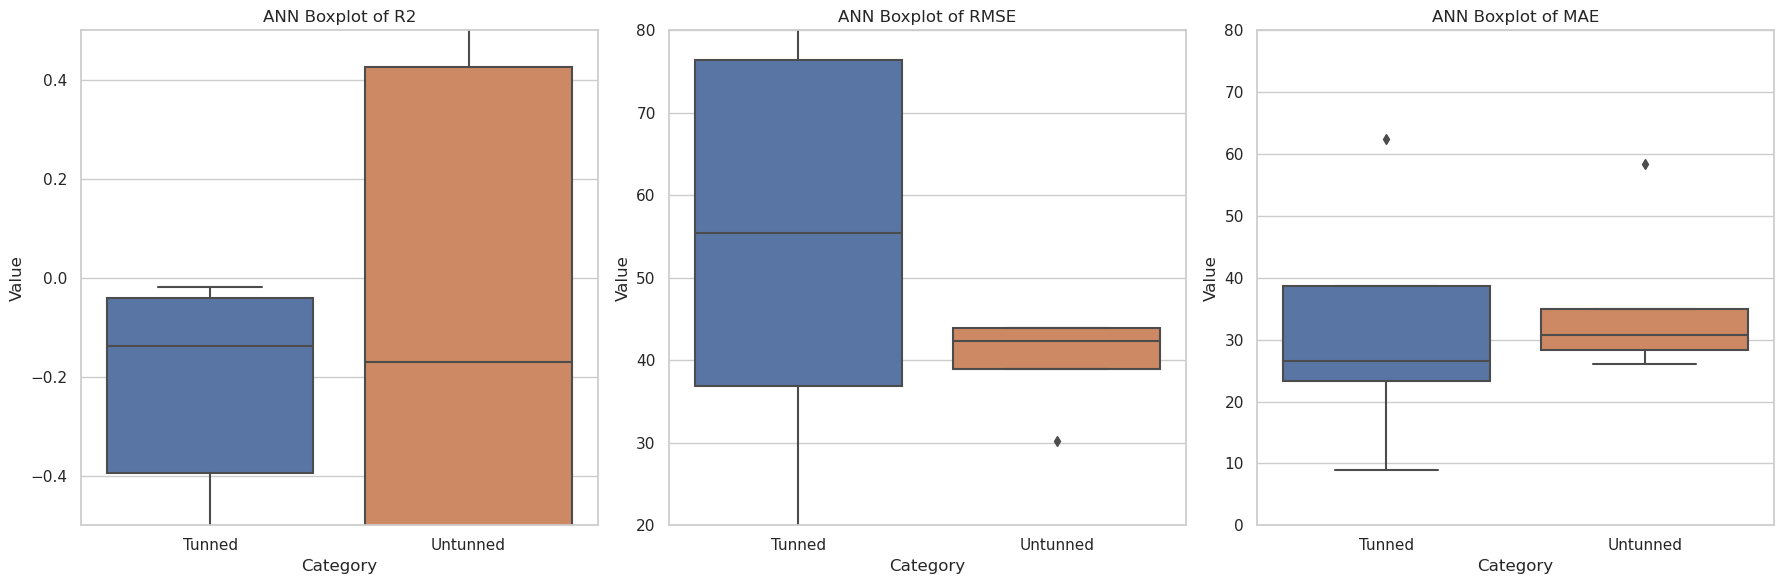

In [54]:
visualize(ann_results, "ANN")

## Results

### Untunned Results

In [55]:
#before fine tuning
untuned_results ={"Scoring": [],
               "random forest":[],
               "decision tree":[],
                "Xgboost": [],
                "gradient boost": [],
                "ann": []
              }
untuned_results["Scoring"].append("r2_score")
untuned_results["random forest"].append(average_untuned_r2_rf)
untuned_results["decision tree"].append(average_untuned_r2_dt)
untuned_results["Xgboost"].append(untunned_xgb_r2)
untuned_results["gradient boost"].append(untunned_test_r2_gb)
untuned_results["ann"].append(untunned_r2_mlp)

untuned_results["Scoring"].append("MAE")
untuned_results["random forest"].append(average_untuned_mae_rf)
untuned_results["decision tree"].append(average_untuned_mae_dt)
untuned_results["Xgboost"].append(untunned_xgb_mae)
untuned_results["gradient boost"].append(untunned_test_mae_gb)
untuned_results["ann"].append(untunned_mae_mlp)

untuned_results["Scoring"].append("RMSE")
untuned_results["random forest"].append(average_untuned_rmse_rf)
untuned_results["decision tree"].append(average_untuned_rmse_dt)
untuned_results["Xgboost"].append(untunned_xgb_rmse)
untuned_results["gradient boost"].append(untunned_test_rmse_gb)
untuned_results["ann"].append(untunned_rmse_mlp)


In [56]:
untuned_results = pd.DataFrame(untuned_results)
untuned_results

,Scoring,random forest,decision tree,Xgboost,gradient boost,ann
0,r2_score,-2.668805,-6.864500,0.125854,0.371110,-0.968391
1,MAE,35.958675,46.111726,35.111087,25.264160,35.708490
2,RMSE,51.330398,65.298542,48.079548,40.780805,48.405579


### Overall finetuned Results

In [57]:
results = {"Scoring": [],
           "random forest":[],
           "decision tree":[],
           "Xgboost":[],
           "Gradient Boost":[],
           "ANN":[]
          }
results["Scoring"].append("r2_score")
results["random forest"].append(mean_rf_r2)
results["decision tree"].append(average_r2_dt)
results["Xgboost"].append(tunned_xgb_r2)
results["Gradient Boost"].append(mean_gbr_r2)
results["ANN"].append(r2_ann)

In [58]:
results["Scoring"].append("MAE")
results["random forest"].append(mean_rf_mae)
results["decision tree"].append(average_mae_dt)
results["Xgboost"].append(tunned_xgb_mae)
results["Gradient Boost"].append(mean_gbr_mae)
results["ANN"].append(mae_ann)

In [59]:
results["Scoring"].append("RMSE")
results["random forest"].append(mean_rf_rmse)
results["decision tree"].append(average_rmse_dt)
results["Xgboost"].append(tunned_xgb_rmse)
results["Gradient Boost"].append(mean_gbr_rmse)
results["ANN"].append(rmse_ann)

In [60]:
df_results = pd.DataFrame(results)
df_results

,Scoring,random forest,decision tree,Xgboost,Gradient Boost,ANN
0,r2_score,0.479291,0.241593,0.263810,0.692320,-0.089418
1,MAE,30.756516,31.849661,33.011986,33.683213,29.802636
2,RMSE,48.843391,53.453625,44.122832,50.480946,53.674222


## Best Parameters

In [61]:
best_params = {
    "ANN":best_params_ann, 
    "Random Forest":best_params_rf, 
    "Decision Tree":best_params_dt,
    "XgBoost":best_params_xgb,
    "Gradient Boost": best_params_gbr,
    
}
best_params

{'ANN': {'activation': 'logistic',
  'hidden_layer_sizes': (10, 10),
  'learning_rate': 'adaptive',
  'learning_rate_init': 0.001,
  'solver': 'adam'},
 'Random Forest': {'max_depth': 8,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 150},
 'Decision Tree': {'splitter': 'random',
  'min_samples_split': 7,
  'min_samples_leaf': 7,
  'max_features': 'log2',
  'max_depth': 14,
  'criterion': 'absolute_error'},
 'XgBoost': {'subsample': 0.6,
  'reg_lambda': 0.2,
  'reg_alpha': 0.3,
  'n_estimators': 100,
  'max_depth': 4,
  'learning_rate': 0.01,
  'gamma': 0.2,
  'colsample_bytree': 0.8},
 'Gradient Boost': {'subsample': 0.9,
  'n_estimators': 50,
  'min_samples_split': 3,
  'min_samples_leaf': 2,
  'max_depth': 5,
  'learning_rate': 0.3}}